In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plant-disease:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4562950%2F8813963%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240711%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240711T200248Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5fcd84ed2d631dfcee73645d5cf81130fdb0883cbb5a9946503f43b202b4c70220f6c45b6147e2bd8a977e731db648a0f987d4364699507fcc803f9ecafefd6fd01ce8d434abc359617240fe800e6235c8f7e0c86e8c5a3c1efb8bdeab0f5bd93eed6e578f860e63efc7d20d8acdbf5dc9b3924715acc9a1f7241ed9fc4ad1b6f80393697ea4350a7ade9da6f6dc74ba27143916191fa4b30794c5199148ae48273e5bea589beb32805a1646bef68b3e29ebb0c02eb3300a98e06418309d0d80a471063341a9c0ccfc747550aed37ea240171b61003959b2a0d8145ca1934c5328293dcf353dbbb5e5b61d07b8c1dab605029c8b429627a75881213e841759c7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16081895452 bytes downloaded
Downloaded and uncompressed: plant-disease
Data source import complete.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, Rescaling, RandomZoom, Resizing, RandomBrightness, RandomContrast

In [6]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory("/kaggle/input/plant-disease/Plant Disease-5-classes/Plant Disease-5/Train/Train",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory("/kaggle/input/plant-disease/Plant Disease-5-classes/Plant Disease-5/Validation/Validation",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory("/kaggle/input/plant-disease/Plant Disease-5-classes/Plant Disease-5/Test/Test",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 400 files belonging to 5 classes.


In [7]:
class_names = train_dataset.class_names

In [8]:
'''class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")'''

'class_names = train_dataset.class_names\n\nplt.figure(figsize=(10, 10))\nfor images, labels in train_dataset.take(1):\n    for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        plt.imshow(images[i].numpy().astype("uint8"))\n        plt.title(class_names[labels[i]])\n        plt.axis("off")'

In [9]:
# data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of multiple layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal", seed=42)),
    data_augmentation.add(RandomRotation(0.2, seed=42, fill_mode="nearest")),
    data_augmentation.add(RandomBrightness(0.2, seed=42)),
    data_augmentation.add(RandomContrast(0.2, seed=42)),
    data_augmentation.add(RandomZoom(0.3, fill_mode="nearest", seed=42)),

    return data_augmentation

In [10]:
'''data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255) # commented as if we use a rescailing layer in the data_augmenter
        plt.axis('off')'''

"data_augmentation = data_augmenter()\n\nfor image, _ in train_dataset.take(1):\n    plt.figure(figsize=(10, 10))\n    first_image = image[0]\n    for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n        plt.imshow(augmented_image[0] / 255) # commented as if we use a rescailing layer in the data_augmenter\n        plt.axis('off')"

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)

In [13]:
# Model

num_classes = len(class_names)

def plant_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for multiclass classification out of the MobileNetV3Large model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV3Large(input_shape=input_shape,
                                                        include_top= False, # <== Important!!!!
                                                        weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv3Large input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmenter()(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)

    x = tfl.Dense(256, activation = 'relu')(x)
    x = tfl.Dropout(0.3)(x)

    x = tfl.Dense(128, activation = 'relu')(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(num_classes, activation = 'softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [14]:
model2 = plant_model(IMG_SIZE, data_augmenter())

12683000/12683000 [==============================] - 2s 0us/step


In [15]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

check_point = tf.keras.callbacks.ModelCheckpoint(
                        filepath="model_with_fine_tuning.keras",
                        save_best_only=True,
                        monitor="val_loss")

In [17]:
initial_epochs = 10
history = model2.fit(train_dataset,
                     validation_data=validation_dataset,
                     epochs=initial_epochs,
                     callbacks=[reduce_lr, check_point, early_stopping])

Epoch 1/10
86/86 [==============================] - 340s 3s/step - loss: 0.7758 - accuracy: 0.6900 - val_loss: 0.6440 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - 325s 3s/step - loss: 0.4564 - accuracy: 0.8175 - val_loss: 0.4988 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 3/10
86/86 [==============================] - 268s 3s/step - loss: 0.3951 - accuracy: 0.8396 - val_loss: 0.5239 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 4/10
86/86 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.8629
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
86/86 [==============================] - 267s 3s/step - loss: 0.3403 - accuracy: 0.8629 - val_loss: 0.5545 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 5/10
86/86 [==============================] - 273s 3s/step - loss: 0.3057 - accuracy: 0.8804 - val_loss: 0.4636 - val_accuracy: 0.8380 - lr: 2.0000e-04
Epoch 6/10
86/86 [==============================] - 259s 3s/step -

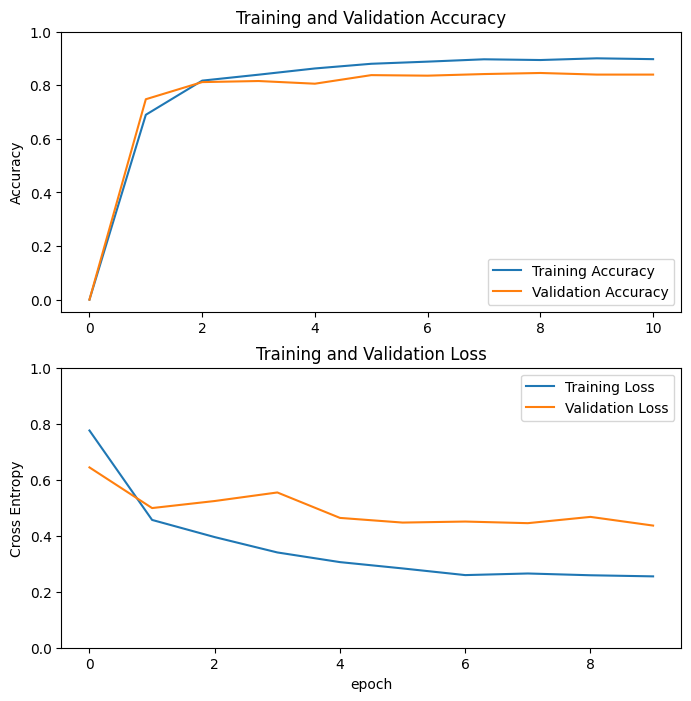

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
class_names

['Healthy', 'Powdery', 'Rust', 'Slug', 'Spot']

In [20]:
# Fine-tuning

base_model = model2.layers[2]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 35

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate),
              metrics=['accuracy'])

Number of layers in the base model:  263


In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

check_point = tf.keras.callbacks.ModelCheckpoint(
                        filepath="model_with_fine_tuning.keras",
                        save_best_only=True,
                        monitor="val_loss")

In [22]:
fine_tune_epochs = 20 # best from graph is 13
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks=[early_stopping, reduce_lr, check_point])

Epoch 10/30
86/86 [==============================] - 303s 3s/step - loss: 0.2511 - accuracy: 0.9055 - val_loss: 0.3383 - val_accuracy: 0.8820 - lr: 1.0000e-04
Epoch 11/30
86/86 [==============================] - 275s 3s/step - loss: 0.1909 - accuracy: 0.9271 - val_loss: 0.4394 - val_accuracy: 0.8640 - lr: 1.0000e-04
Epoch 12/30
86/86 [==============================] - 264s 3s/step - loss: 0.1674 - accuracy: 0.9349 - val_loss: 0.2712 - val_accuracy: 0.9020 - lr: 1.0000e-04
Epoch 13/30
86/86 [==============================] - 261s 3s/step - loss: 0.1506 - accuracy: 0.9429 - val_loss: 0.2973 - val_accuracy: 0.8940 - lr: 1.0000e-04
Epoch 14/30
86/86 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9518
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
86/86 [==============================] - 271s 3s/step - loss: 0.1323 - accuracy: 0.9518 - val_loss: 0.3826 - val_accuracy: 0.8760 - lr: 1.0000e-04
Epoch 15/30
86/86 [=========================

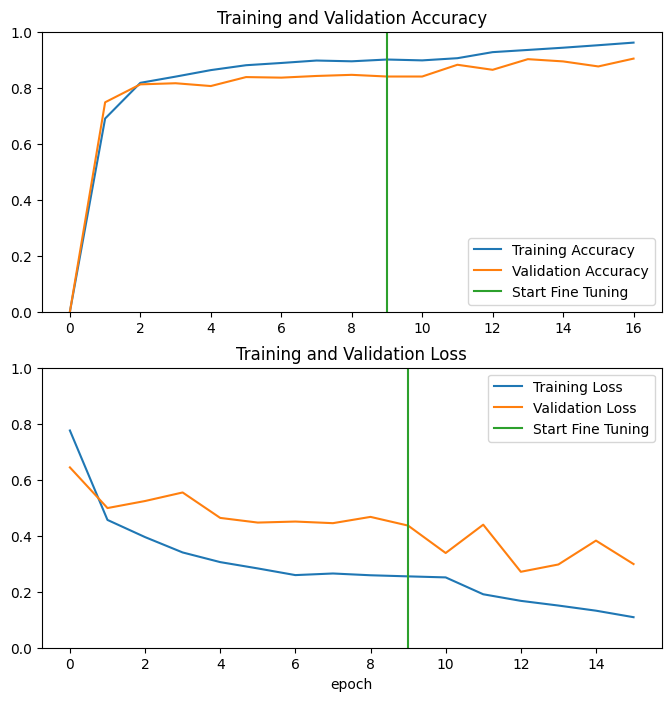

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
loss, accuracy = model2.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)
print("Validation Loss :", loss)

8/8 [==============================] - 16s 82ms/step - loss: 0.2988 - accuracy: 0.9040
Validation accuracy : 0.9039999842643738
Validation Loss : 0.2988119423389435


In [25]:
loss, accuracy = model2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print("Test Loss :", loss)

7/7 [==============================] - 16s 274ms/step - loss: 0.3122 - accuracy: 0.9150
Test accuracy : 0.9150000214576721
Test Loss : 0.31216245889663696


In [26]:
'''# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model2.predict_on_batch(image_batch).flatten()

predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]

y_actual_index = []
y_pred_index = []

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_class_name = class_names[labels[i]]
        y_actual_index.append(labels[i])
        current_image = np.expand_dims(images[i], axis=0)
        current_prediction = model2.predict(current_image)
        current_predicted_class_index = np.argmax(current_prediction[0])
        y_pred_index.append(current_predicted_class_index)
        current_predicted_class_name = class_names[current_predicted_class_index]

        # Use plt.text for subtitles (adjust positions as needed)
        plt.text(0.05, 0.85, f"Actual: {actual_class_name}", ha='left', va='top', fontsize=8)
        plt.text(0.05, 0.95, f"Predicted: {current_predicted_class_name}", ha='left', va='bottom', fontsize=8)

        plt.axis("off")
plt.tight_layout()  # Adjust spacing between subplots
plt.show()'''

'# Retrieve a batch of images from the test set\nimage_batch, label_batch = test_dataset.as_numpy_iterator().next()\npredictions = model2.predict_on_batch(image_batch).flatten()\n\npredicted_class_index = np.argmax(predictions[0])\npredicted_class_name = class_names[predicted_class_index]\n\ny_actual_index = []\ny_pred_index = []\n\nplt.figure(figsize=(10, 10))\nfor images, labels in test_dataset.take(1):\n    for i in range(32):\n        ax = plt.subplot(8, 4, i + 1)\n        plt.imshow(images[i].numpy().astype("uint8"))\n        actual_class_name = class_names[labels[i]]\n        y_actual_index.append(labels[i])\n        current_image = np.expand_dims(images[i], axis=0)\n        current_prediction = model2.predict(current_image)\n        current_predicted_class_index = np.argmax(current_prediction[0])\n        y_pred_index.append(current_predicted_class_index)\n        current_predicted_class_name = class_names[current_predicted_class_index]\n\n        # Use plt.text for subtitles (a

In [30]:
test_dataset1 = test_dataset = image_dataset_from_directory("/kaggle/input/plant-disease/Plant Disease-5-classes/Plant Disease-5/Test/Test",
                                             batch_size=400,
                                             image_size=IMG_SIZE)

Found 400 files belonging to 5 classes.


In [ ]:
# Retrieve a batch of images from the test set
'''image_batch1, label_batch1 = test_dataset1.as_numpy_iterator().next()
predictions1 = model2.predict_on_batch(image_batch1).flatten()

predicted_class_index1 = np.argmax(predictions1[0])
predicted_class_name1 = class_names[predicted_class_index1]

predicted_labels = []

plt.figure(figsize=(30, 20))
for images1, labels1 in test_dataset1.take(1):
    for i in range(342):
        ax = plt.subplot(20, 20, i + 1)
        plt.imshow(images1[i].numpy().astype("uint8"))
        actual_class_name1 = class_names[labels1[i]]
        current_image1 = np.expand_dims(images1[i], axis=0)
        current_prediction1 = model2.predict(current_image1)
        current_predicted_class_index1 = np.argmax(current_prediction1[0])
        predicted_labels.append(current_predicted_class_index1)
        current_predicted_class_name1 = class_names[current_predicted_class_index1]

        # Use plt.text for subtitles (adjust positions as needed)
        plt.text(0.05, 0.85, f"Actual: {actual_class_name1}", ha='left', va='top', fontsize=8)
        plt.text(0.05, 0.95, f"Predicted: {current_predicted_class_name1}", ha='left', va='bottom', fontsize=8)

        plt.axis("off")
plt.tight_layout()  # Adjust spacing between subplots
plt.show()'''

13/13 [==============================] - 3s 37ms/step


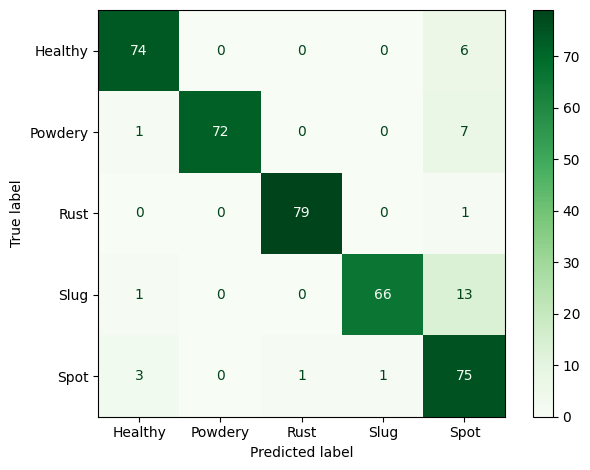

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the entire test dataset
predicted_labels = []
true_labels = []

for images, labels in test_dataset1:
    predictions = model2.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels)

# Convert true labels to numpy array
true_labels = np.array(true_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp_cm = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp_cm.plot(cmap="Greens")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

     Healthy       0.94      0.93      0.93        80
     Powdery       1.00      0.90      0.95        80
        Rust       0.99      0.99      0.99        80
        Slug       0.99      0.82      0.90        80
        Spot       0.74      0.94      0.82        80

    accuracy                           0.92       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.92      0.92       400



In [33]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [34]:
model = model2

# Convert the TensorFlow model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('plant_modelـlatestv.tflite', 'wb') as f:
    f.write(tflite_model)

In [35]:
model.save("plant_model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
